In [1]:
from class_np_maker import np_maker as np_m
from bagpy import bagreader
from bag_reader import Read_Ros_Bag
import tensorflow as tf
from tqdm import trange
print(tf.__version__)

2.4.1


In [2]:
rosbag_reader = Read_Ros_Bag(path=r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\pedestrian_on_road\2021-03-12_11-29-58\2021-03-12_11-29-59_0.bag')
data_params = rosbag_reader.msgs()

#np_image_data = convert_2_np.create_np_img()

[INFO]  Data folder C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\pedestrian_on_road\2021-03-12_11-29-58\2021-03-12_11-29-59_0 already exists. Not creating.


In [16]:
convert_2_np = np_m(max_length=25,**data_params)

np_init_path,np_opt_path = convert_2_np.create_np_path()

np_grid_data = convert_2_np.create_np_grid()

bag_name = rosbag_reader.bag_name

print(bag_name)

  1%|          | 1/179 [00:00<00:20,  8.85it/s]Converting path data to numpy........ 
Converting grid data to numpy........ 
100%|██████████| 179/179 [00:19<00:00,  9.12it/s]
2021-03-12_11-29-59_0


In [5]:
print(type(np_init_path[0][0][0]))

<class 'numpy.float64'>


## tf.train.example (serialization of data)

In [6]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value.tostring()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tostring()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, init_path, opt_path):
    feature = {
        "image": image_feature(image),
        "init_path": bytes_feature(init_path),
        "opt_path": bytes_feature(opt_path),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



## Create tf records

In [12]:
num_samples = 10
tfrecords_dir = r'C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\tf_records\records'

assert len(np_grid_data)==len(np_init_path)==len(np_opt_path)

num_tfrecods = len(np_grid_data) // num_samples

if len(np_grid_data) % num_samples:
    num_tfrecods += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir) 


for tfrec_num in trange(num_tfrecods):
    samples = np_grid_data[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for i in range(len(samples)):
            #print(np.shape(np_init_path[i]))
            example = create_example(np_grid_data[i], np_init_path[i], np_opt_path[i])
            writer.write(example.SerializeToString())




  0%|          | 0/18 [00:00<?, ?it/s]ipykernel_launcher:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
ipykernel_launcher:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.



  6%|▌         | 1/18 [00:00<00:06,  2.49it/s]


 11%|█         | 2/18 [00:00<00:06,  2.59it/s]


 17%|█▋        | 3/18 [00:01<00:05,  2.68it/s]


 22%|██▏       | 4/18 [00:01<00:05,  2.67it/s]


 28%|██▊       | 5/18 [00:01<00:04,  2.72it/s]


 33%|███▎      | 6/18 [00:02<00:04,  2.69it/s]


 39%|███▉      | 7/18 [00:02<00:04,  2.70it/s]


 44%|████▍     | 8/18 [00:02<00:03,  2.72it/s]


 50%|█████     | 9/18 [00:03<00:03,  2.72it/s]


 56%|█████▌    | 10/18 [00:03<00:02,  2.76it/s]


 61%|██████    | 11/18 [00:04<00:02,  2.82it/s]


 67%|██████▋   | 12/18 [00:04<00:02,  2.81it/s]


 72%|███████▏  | 13/18 [00:04<00:01,  2.75it/s]


 78%|███████▊  | 14/18 [00:05<00:01,  2.75it/s]


 83%|████████▎ | 15/18 [00:05<00:01,  2.71it/s]


 89%|████████▉ | 16/18 [00:05<00:

init_path: (50,)
opt_path: (50,)


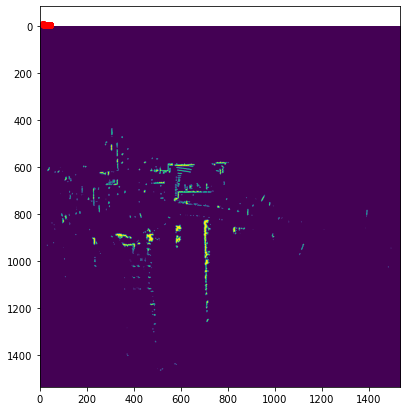

In [20]:
from matplotlib import pyplot as plt
import io
import numpy as np 

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        "opt_path": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example

raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {np.shape(tf.io.decode_raw(features[key],out_type=tf.float64).numpy())}")
    init_path = np.reshape(tf.io.decode_raw(features['init_path'],out_type=tf.float64).numpy(),(25,2))
    image = tf.io.decode_raw(features['image'], out_type=tf.float32).numpy()
    #print((init_path))
    image = np.reshape(image,(1536,1536))
    #print(type(image))
    #print(f"Image shape: {tf.io.decode_raw(features['image'], out_type=tf.float32)}")
    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    plt.plot(init_path[:,0],init_path[:,1],'o-', color='red')
    plt.show()

init_path: (25, 2)
opt_path: (25, 2)
<class 'numpy.ndarray'>


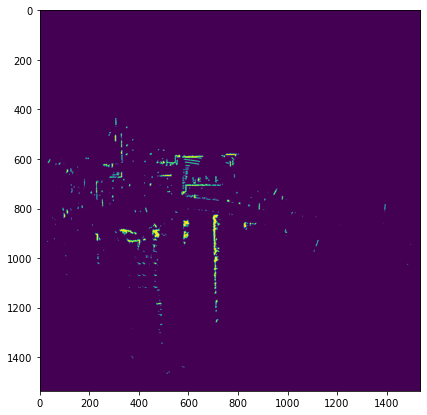

In [36]:
def prepare_sample(example):
    example["image"] = tf.io.decode_raw(example["image"], out_type=tf.float32)
    example["image"] = tf.reshape(example["image"],[1536,1536])
    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float64)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float64)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])
    return example

def parse_tfrecord_fn_ds(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        "opt_path": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example


# sample data poinfrom tf record
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn_ds).map(prepare_sample)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {np.shape(features[key].numpy())}")
    image = features["image"].numpy()
    print(type(image))
    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    #plt.plot(init_path[:,0],init_path[:,1],'o-', color='red')
    plt.show()




# Preparing Data pipeline from tf records

In [3]:
def prepare_sample(example):
    example["image"] = tf.io.decode_raw(example["image"], out_type=tf.float32)
    example["image"] = tf.reshape(example["image"],[1536,1536])
    example["init_path"] = tf.io.decode_raw(example["init_path"], out_type=tf.float64)
    example["init_path"] = tf.reshape(example["init_path"],[25,2])

    example["opt_path"] = tf.io.decode_raw(example["opt_path"], out_type=tf.float64)
    example["opt_path"] = tf.reshape(example["opt_path"],[25,2])
    return (example["image"],example["init_path"]),example["opt_path"]

def parse_tfrecord_fn_ds(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "init_path": tf.io.FixedLenFeature([], tf.string),
        "opt_path": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example

def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn_ds, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset


tfrecords_dir = r'D:\tf_records'
             #C:\Users\Teja\Documents\_INFOTECH\Thesis\sample_Ros_bag\tf_record#s\records


train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")

batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(len(train_filenames))

0


In [30]:
import random
from sklearn.model_selection import train_test_split

batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE


list_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
random.shuffle(list_filenames)

list_train,list_test= train_test_split(list_filenames,test_size=0.2)
list_train,list_valid= train_test_split(list_train,test_size=0.1)

print(len(list_train),len(list_test),len(list_valid))

12 4 2


In [31]:
ds_train= get_dataset(list_train,batch_size)
ds_test= get_dataset(list_test,batch_size)
ds_valid= get_dataset(list_valid,batch_size)
print((ds_train.element_spec))

((TensorSpec(shape=(None, 1536, 1536), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25, 2), dtype=tf.float64, name=None)), TensorSpec(shape=(None, 25, 2), dtype=tf.float64, name=None))


In [32]:
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow.keras.backend as K


def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_p red: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    #original euclidean distance loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    loss = K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))
    return loss

def nn():

    # define two sets of inputs
    input_A = layers.Input(shape=(1536,1536,1))
    input_B = layers.Input(shape=(25,2))

    #branch 1
    x_B = layers.Conv1D(2,kernel_size=3,padding='same')(input_B)

    reshape_input_B = layers.Reshape((50,))(x_B)

    #CNN - branch2
    x_A = layers.Conv2D(16,kernel_size=7,strides=2)(input_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    x_A = layers.Conv2D(32,kernel_size=5,strides=2)(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)

    
    x_A = layers.Conv2D(64,kernel_size=3,strides=2)(x_A)
    x_A = layers.BatchNormalization()(x_A)
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(2,2))(x_A)


    x_A = layers.Flatten()(x_A)
    
    #concatenate feature
    concat_feat = layers.concatenate([x_A, reshape_input_B])

    #concat_feat = layers.Lambda(lambda x: tf.expand_dims(x, -1))(concat_feat)

    #FC
    #output = layers.Convolution1D(50,kernel_size=3,padding='valid',activation='relu')(concat_feat)
    
    output = layers.Dense(50, activation='linear')(concat_feat)

    output = layers.Dropout(0.6)(output)
    
    output = layers.Dense(50, activation='linear')(output)
    
    output = layers.Reshape((25,2))(output)
    

    nn_fun = keras.models.Model(inputs = [input_A, input_B], outputs= output)
    
    return nn_fun
    

In [33]:
pp_model = nn()
opt = tf.keras.optimizers.Adam()
pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')
pp_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 765, 765, 16) 800         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 765, 765, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_15 (ReLU)                 (None, 765, 765, 16) 0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [34]:
history = pp_model.fit(ds_train,epochs=100,validation_data=ds_valid)

Epoch 1/100
4/4 [==============================] - 46s 11s/step - loss: 32.9486 - accuracy: 0.4987 - val_loss: 32.0531 - val_accuracy: 0.8000
Epoch 2/100
4/4 [==============================] - 43s 11s/step - loss: 31.8239 - accuracy: 0.6874 - val_loss: 30.8016 - val_accuracy: 0.9200
Epoch 3/100
4/4 [==============================] - 48s 11s/step - loss: 30.7029 - accuracy: 0.7876 - val_loss: 29.1788 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 45s 11s/step - loss: 29.0366 - accuracy: 0.8441 - val_loss: 27.0006 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 48s 12s/step - loss: 26.9746 - accuracy: 0.8743 - val_loss: 24.1471 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 50s 12s/step - loss: 24.9117 - accuracy: 0.8964 - val_loss: 20.6881 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 52s 13s/step - loss: 22.3581 - accuracy: 0.9307 - val_loss: 17.0862 - val_accuracy: 1.0000
Epoch 

In [ ]:
pp_model.save("")